<a href="https://colab.research.google.com/github/Yohan0358/Study_GAN/blob/main/LSGAN(210730).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision import utils

import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device type : ', device)

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 28 * 28
epochs = 100
batch_size = 100
lr = 0.0002

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.5], std = [0.5])   # 1 channel
                                ])

device type :  cpu


In [ ]:
# 데이터 다운로드
mnist = datasets.MNIST('./mnist/',
                       train = True,
                       transform = transform,
                       download = True)

# dataloader
data_loader = DataLoader(mnist, 
                         batch_size = batch_size, 
                         shuffle = True)

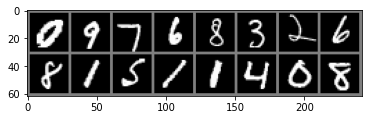

In [4]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap = 'gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

ex_batch_img, _ = next(iter(data_loader))
imshow_grid(ex_batch_img[:16, :])

In [9]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_size = latent_size, hidden_size = hidden_size, image_size = image_size):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(latent_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, image_size)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        x = nn.Tanh()(self.lin3(x))
        return x


class Descriminator(nn.Module):
    def __init__(self, input_size = image_size, hidden_size = hidden_size):
        super(Descriminator, self).__init__()

        self.lin1 = nn.Linear(input_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        # x = nn.Sigmoid()(self.lin3(x))
        x = self.lin3(x)
        return x

In [6]:
# noise define
def generate_noise(latent_size = latent_size, batch_size = batch_size):
    return torch.randn(batch_size, latent_size)

z = generate_noise().to(device)

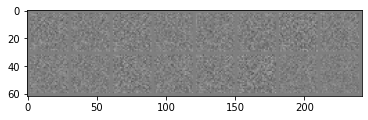

In [7]:
G = Generator().to(device)
D = Descriminator().to(device)
img_fake = G(z).view(-1, 1, 28, 28)

imshow_grid(img_fake[:16])

In [8]:
# Optimizer
G_optim = torch.optim.Adam(G.parameters(), lr = lr)
D_optim = torch.optim.Adam(D.parameters(), lr = lr)

# Loss function(Least Square Loss - L1 Loss)
criterion = nn.L1Loss()

In [29]:
# training

def LSGAN_train(epochs = epochs):
    dloss_list = []
    gloss_list = []
    for epoch in range(epochs):
        d_losses = 0
        g_losses = 0
        for i, (image, _) in enumerate(data_loader):

            image = image.view(-1, 28 * 28 ).to(device)

            z = generate_noise().to(device)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            fake_img = G(z)

            # Descriminator 학습

            real_loss = criterion(D(image), real_labels)
            fake_loss = criterion(D(fake_img.detach()), fake_labels)

            d_loss = real_loss + fake_loss

            D_optim.zero_grad()
            d_loss.backward()
            D_optim.step()

            # Generator 학습

            g_loss = criterion(D(fake_img), real_labels)
            G_optim.zero_grad()
            g_loss.backward()
            G_optim.step()

            d_losses += d_loss / len(data_loader)
            g_losses += g_loss / len(data_loader)

        print(f'[{epoch + 1} / {epochs}] D_loss : {d_losses:.4f} \t G_loss : {g_losses:.4f}')     

        if (epoch + 1) % 20 == 0:
            imshow_grid(G(z).view(-1, 1, 28, 28)[:16])

        dloss_list.append(d_losses)
        gloss_list.append(g_losses)

    plt.plot(dloss_list, label = 'D_loss')
    plt.plot(gloss_list, label = 'G_loss')
    plt.legend()
    plt.show()
    return dloss_list, gloss_list

[1 / 100] D_loss : 0.8796 	 G_loss : 2.0271
[2 / 100] D_loss : 0.8313 	 G_loss : 2.1782
[3 / 100] D_loss : 0.7411 	 G_loss : 2.4151
[4 / 100] D_loss : 0.8153 	 G_loss : 2.1679
[5 / 100] D_loss : 0.8489 	 G_loss : 2.0734
[6 / 100] D_loss : 0.9487 	 G_loss : 1.9661
[7 / 100] D_loss : 0.5591 	 G_loss : 2.6477
[8 / 100] D_loss : 0.5475 	 G_loss : 2.8432
[9 / 100] D_loss : 0.5242 	 G_loss : 2.8682
[10 / 100] D_loss : 0.5508 	 G_loss : 3.4439
[11 / 100] D_loss : 0.4411 	 G_loss : 3.1332
[12 / 100] D_loss : 0.4051 	 G_loss : 3.2549
[13 / 100] D_loss : 0.4421 	 G_loss : 3.3068
[14 / 100] D_loss : 0.6273 	 G_loss : 3.0116
[15 / 100] D_loss : 0.6973 	 G_loss : 3.0611
[16 / 100] D_loss : 0.6256 	 G_loss : 2.7488
[17 / 100] D_loss : 0.5347 	 G_loss : 2.9286
[18 / 100] D_loss : 0.5915 	 G_loss : 3.2725
[19 / 100] D_loss : 0.5604 	 G_loss : 2.8927
[20 / 100] D_loss : 0.5072 	 G_loss : 2.8365


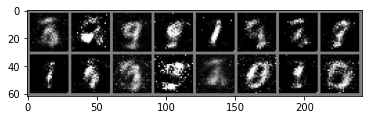

[21 / 100] D_loss : 0.5259 	 G_loss : 3.1386
[22 / 100] D_loss : 0.5154 	 G_loss : 3.0295
[23 / 100] D_loss : 0.5632 	 G_loss : 2.8445
[24 / 100] D_loss : 0.6140 	 G_loss : 2.7490
[25 / 100] D_loss : 0.6168 	 G_loss : 2.6301
[26 / 100] D_loss : 0.5661 	 G_loss : 2.5917
[27 / 100] D_loss : 0.5727 	 G_loss : 2.5088
[28 / 100] D_loss : 0.5760 	 G_loss : 2.4894
[29 / 100] D_loss : 0.5846 	 G_loss : 2.7277
[30 / 100] D_loss : 0.6318 	 G_loss : 2.7478
[31 / 100] D_loss : 0.5963 	 G_loss : 2.6715
[32 / 100] D_loss : 0.6579 	 G_loss : 2.4939
[33 / 100] D_loss : 0.6633 	 G_loss : 2.3469
[34 / 100] D_loss : 0.6636 	 G_loss : 2.2397
[35 / 100] D_loss : 0.6854 	 G_loss : 2.3876
[36 / 100] D_loss : 0.6861 	 G_loss : 2.3114
[37 / 100] D_loss : 0.7115 	 G_loss : 2.1710
[38 / 100] D_loss : 0.7255 	 G_loss : 2.0792
[39 / 100] D_loss : 0.7255 	 G_loss : 2.1406
[40 / 100] D_loss : 0.7266 	 G_loss : 2.1115


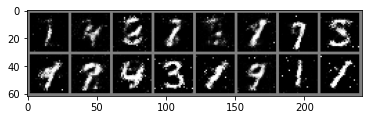

[41 / 100] D_loss : 0.6868 	 G_loss : 2.1274
[42 / 100] D_loss : 0.6891 	 G_loss : 2.1604
[43 / 100] D_loss : 0.7076 	 G_loss : 2.1829
[44 / 100] D_loss : 0.7070 	 G_loss : 2.1152
[45 / 100] D_loss : 0.7284 	 G_loss : 2.1075
[46 / 100] D_loss : 0.7468 	 G_loss : 2.0177
[47 / 100] D_loss : 0.7471 	 G_loss : 2.0221
[48 / 100] D_loss : 0.7472 	 G_loss : 2.0094
[49 / 100] D_loss : 0.7469 	 G_loss : 2.0182
[50 / 100] D_loss : 0.7602 	 G_loss : 1.9852
[51 / 100] D_loss : 0.7633 	 G_loss : 1.9558
[52 / 100] D_loss : 0.7693 	 G_loss : 1.9670
[53 / 100] D_loss : 0.7844 	 G_loss : 1.9241
[54 / 100] D_loss : 0.7861 	 G_loss : 1.8986
[55 / 100] D_loss : 0.7966 	 G_loss : 1.8734
[56 / 100] D_loss : 0.7958 	 G_loss : 1.8964
[57 / 100] D_loss : 0.7988 	 G_loss : 1.8888
[58 / 100] D_loss : 0.8102 	 G_loss : 1.8778
[59 / 100] D_loss : 0.8312 	 G_loss : 1.8070
[60 / 100] D_loss : 0.8162 	 G_loss : 1.8089


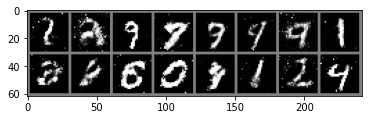

[61 / 100] D_loss : 0.8218 	 G_loss : 1.7804
[62 / 100] D_loss : 0.8107 	 G_loss : 1.8301
[63 / 100] D_loss : 0.8197 	 G_loss : 1.8143
[64 / 100] D_loss : 0.8369 	 G_loss : 1.7552
[65 / 100] D_loss : 0.8240 	 G_loss : 1.7823
[66 / 100] D_loss : 0.8385 	 G_loss : 1.7710
[67 / 100] D_loss : 0.8356 	 G_loss : 1.7392
[68 / 100] D_loss : 0.8438 	 G_loss : 1.7466
[69 / 100] D_loss : 0.8459 	 G_loss : 1.7550
[70 / 100] D_loss : 0.8547 	 G_loss : 1.7615
[71 / 100] D_loss : 0.8460 	 G_loss : 1.7402
[72 / 100] D_loss : 0.8553 	 G_loss : 1.7032
[73 / 100] D_loss : 0.8454 	 G_loss : 1.7325
[74 / 100] D_loss : 0.8488 	 G_loss : 1.7428
[75 / 100] D_loss : 0.8548 	 G_loss : 1.7098
[76 / 100] D_loss : 0.8539 	 G_loss : 1.7222
[77 / 100] D_loss : 0.8531 	 G_loss : 1.7140
[78 / 100] D_loss : 0.8614 	 G_loss : 1.6885
[79 / 100] D_loss : 0.8591 	 G_loss : 1.7015
[80 / 100] D_loss : 0.8601 	 G_loss : 1.6704


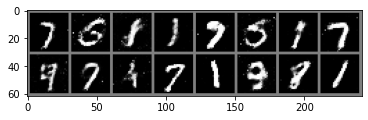

[81 / 100] D_loss : 0.8621 	 G_loss : 1.6808
[82 / 100] D_loss : 0.8501 	 G_loss : 1.6967
[83 / 100] D_loss : 0.8561 	 G_loss : 1.6987
[84 / 100] D_loss : 0.8599 	 G_loss : 1.7055
[85 / 100] D_loss : 0.8685 	 G_loss : 1.6643
[86 / 100] D_loss : 0.8589 	 G_loss : 1.6837
[87 / 100] D_loss : 0.8726 	 G_loss : 1.6528
[88 / 100] D_loss : 0.8652 	 G_loss : 1.6778
[89 / 100] D_loss : 0.8641 	 G_loss : 1.6635
[90 / 100] D_loss : 0.8607 	 G_loss : 1.6612
[91 / 100] D_loss : 0.8689 	 G_loss : 1.6853
[92 / 100] D_loss : 0.8665 	 G_loss : 1.6595
[93 / 100] D_loss : 0.8677 	 G_loss : 1.6656
[94 / 100] D_loss : 0.8577 	 G_loss : 1.6967
[95 / 100] D_loss : 0.8650 	 G_loss : 1.6674
[96 / 100] D_loss : 0.8647 	 G_loss : 1.6831
[97 / 100] D_loss : 0.8627 	 G_loss : 1.6916
[98 / 100] D_loss : 0.8605 	 G_loss : 1.6693
[99 / 100] D_loss : 0.8643 	 G_loss : 1.6792
[100 / 100] D_loss : 0.8573 	 G_loss : 1.6804


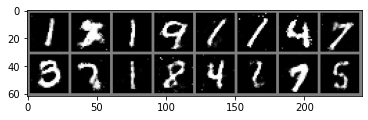

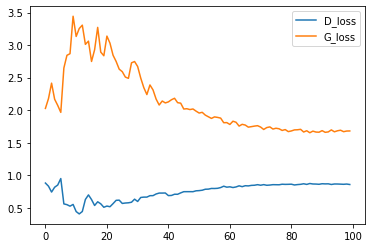

In [30]:
dloss, gloss = LSGAN_train(100)

In [ ]:
# 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')